In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


In [ ]:
print(tensorflow.config.list_physical_devices("GPU"))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]
________________________________________________
False


In [ ]:
print("Current tensorflow version == {}".format(tensorflow. __version__))

Current tensorflow version == 2.13.0


In [ ]:
train_df = glob.glob("/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/**/*.jpeg")
test_df = glob.glob("/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...


In [ ]:
train_df[:5], test_df[:5]

(['/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0523-0001-0001.jpeg',
  '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0511-0001-0001.jpeg',
  '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0517-0001.jpeg',
  '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0509-0001-0001.jpeg',
  '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0525-0001-0002.jpeg'],
 ['/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test/PNEUMONIA/person133_bacteria_638.jpeg',
  '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test/PNEUMONIA/person150_bacteria_716.jpeg',
  '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg',
  '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_

**Do some Data Exploration**


In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5232 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


In [ ]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4289
The number of non-pneumonia images is 1583


**Shuffle the images**

In [ ]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0764-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test/NORMAL/IM-0110-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0381-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0413-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0616-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1130-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0245-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0180-0001.jpeg',
 '/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0328-0001.jpeg',

NORMAL


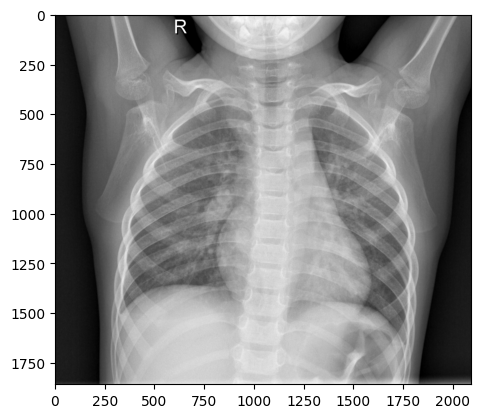

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


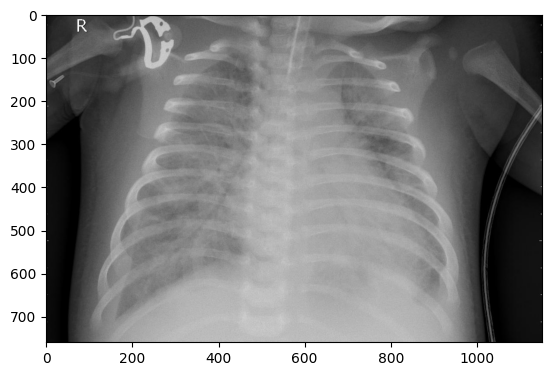

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIA")
plt.imshow(normal_lung_image)
plt.show()

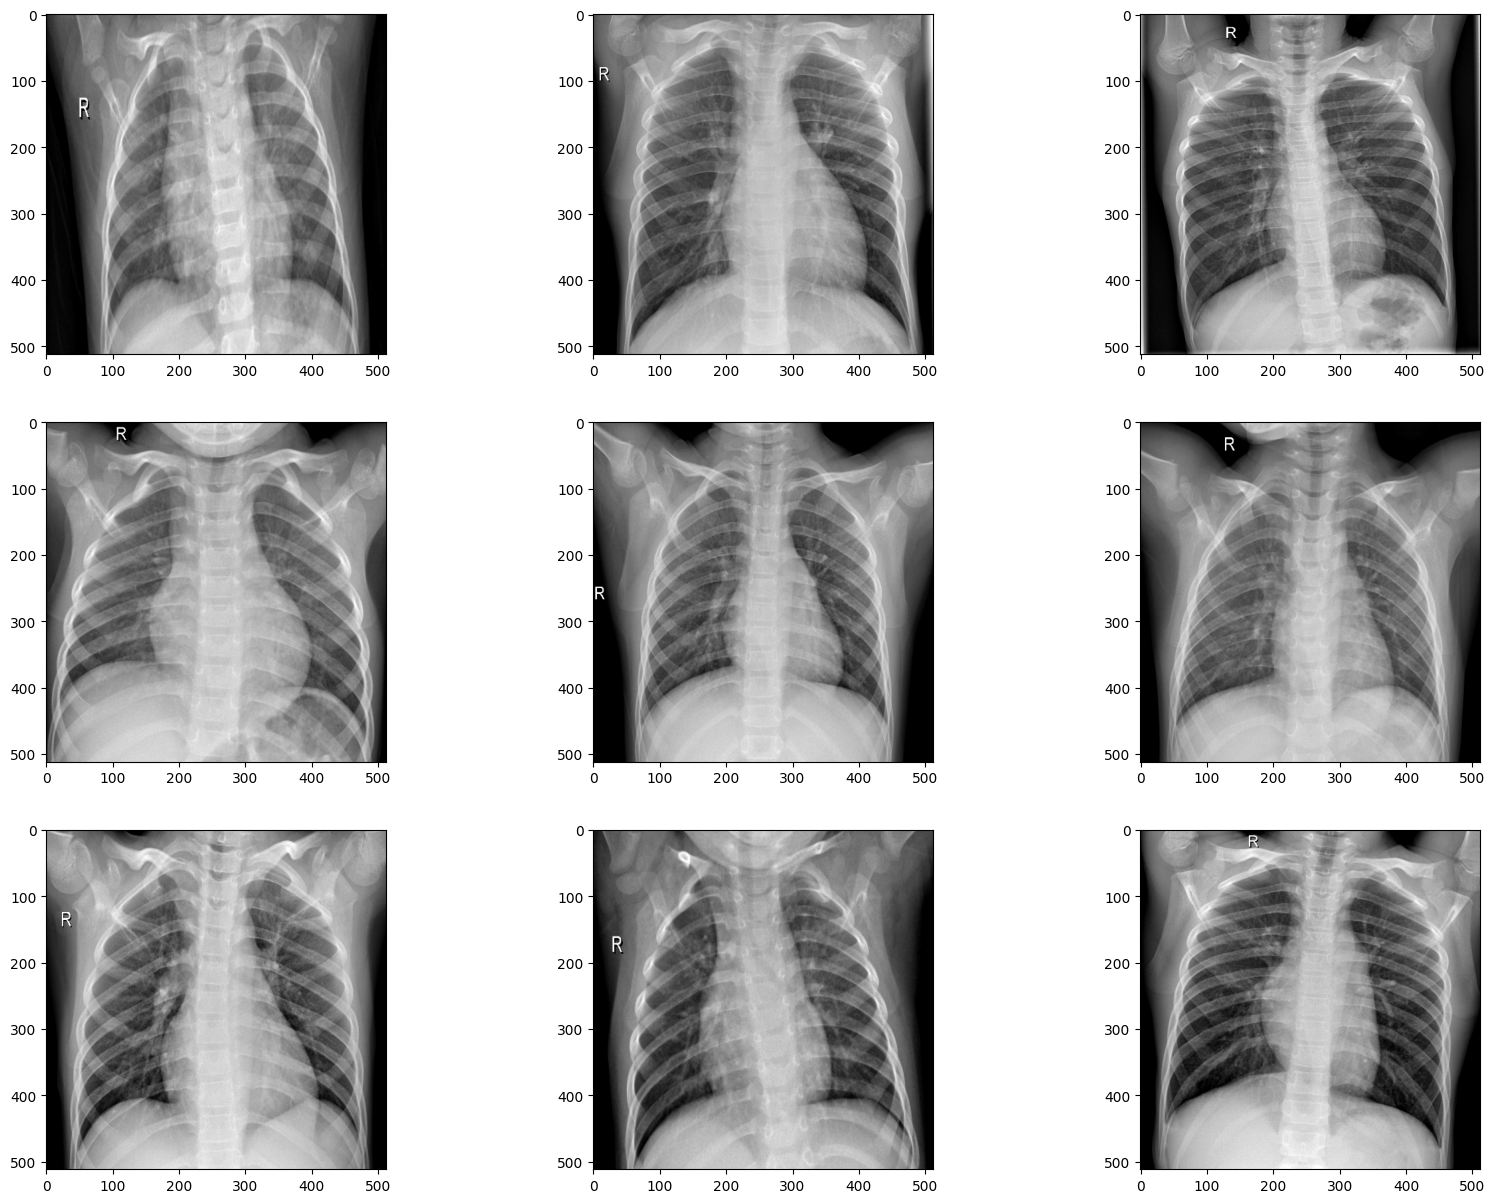

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

**Image Erosion**

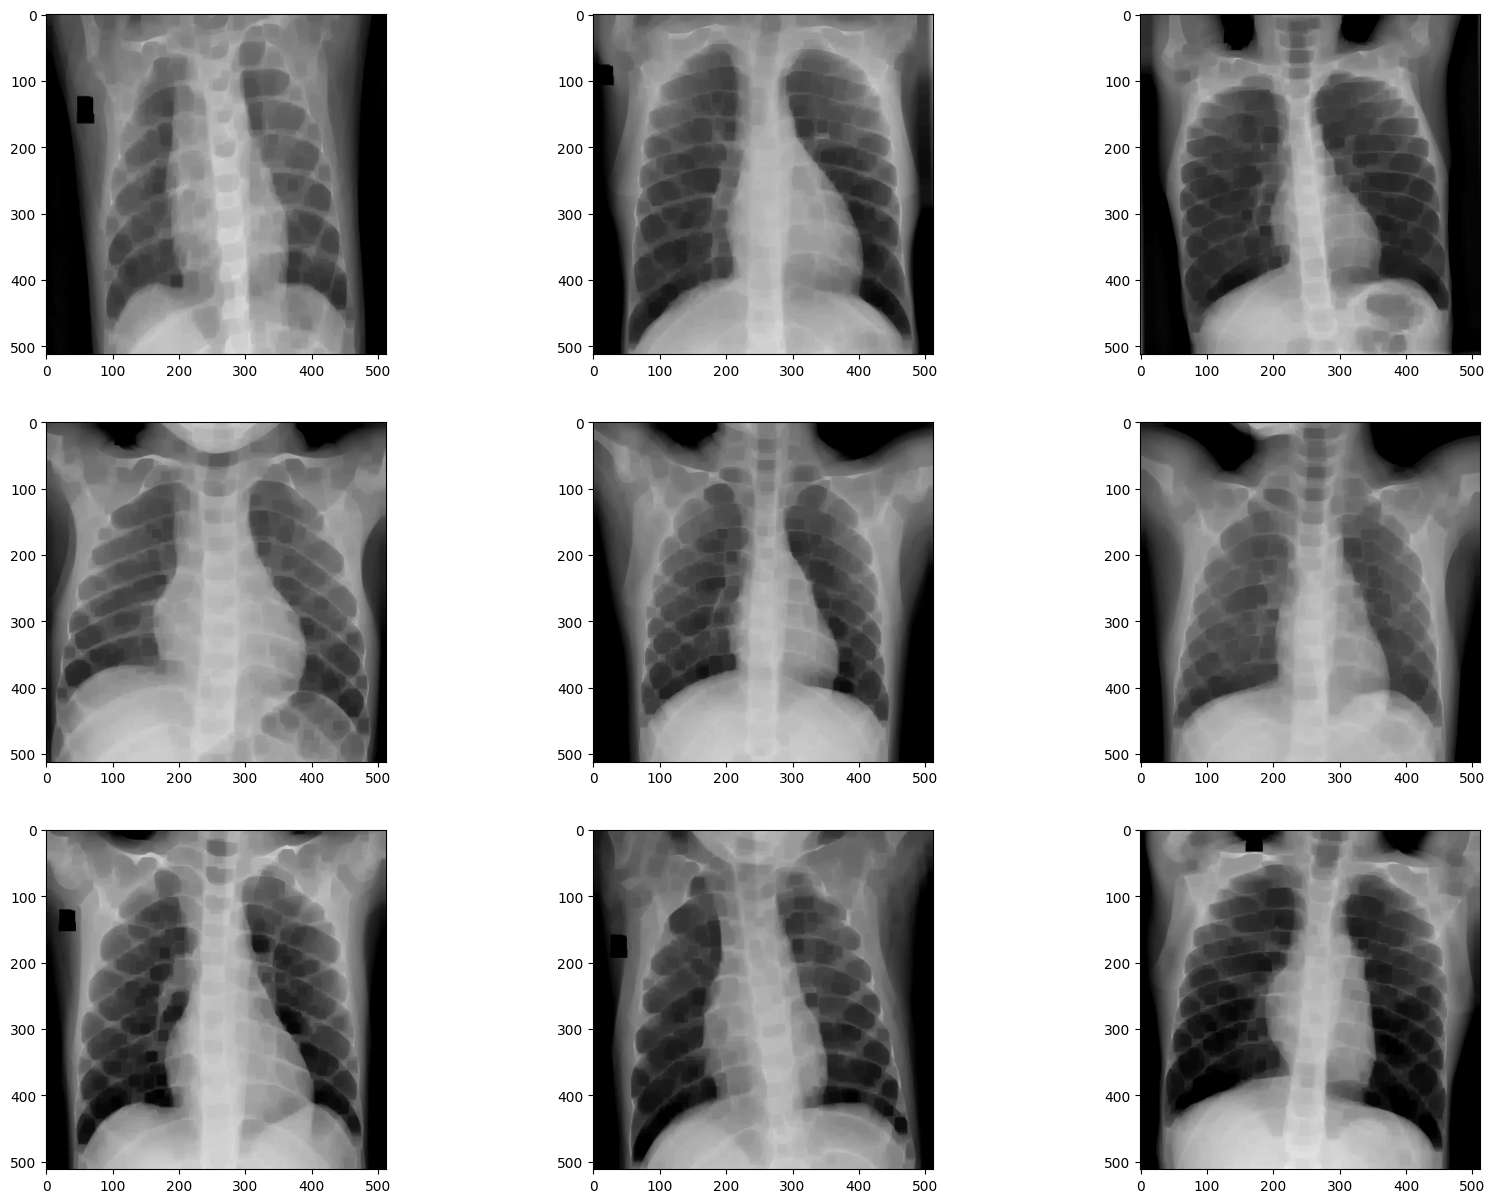

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

**Image Dialation**

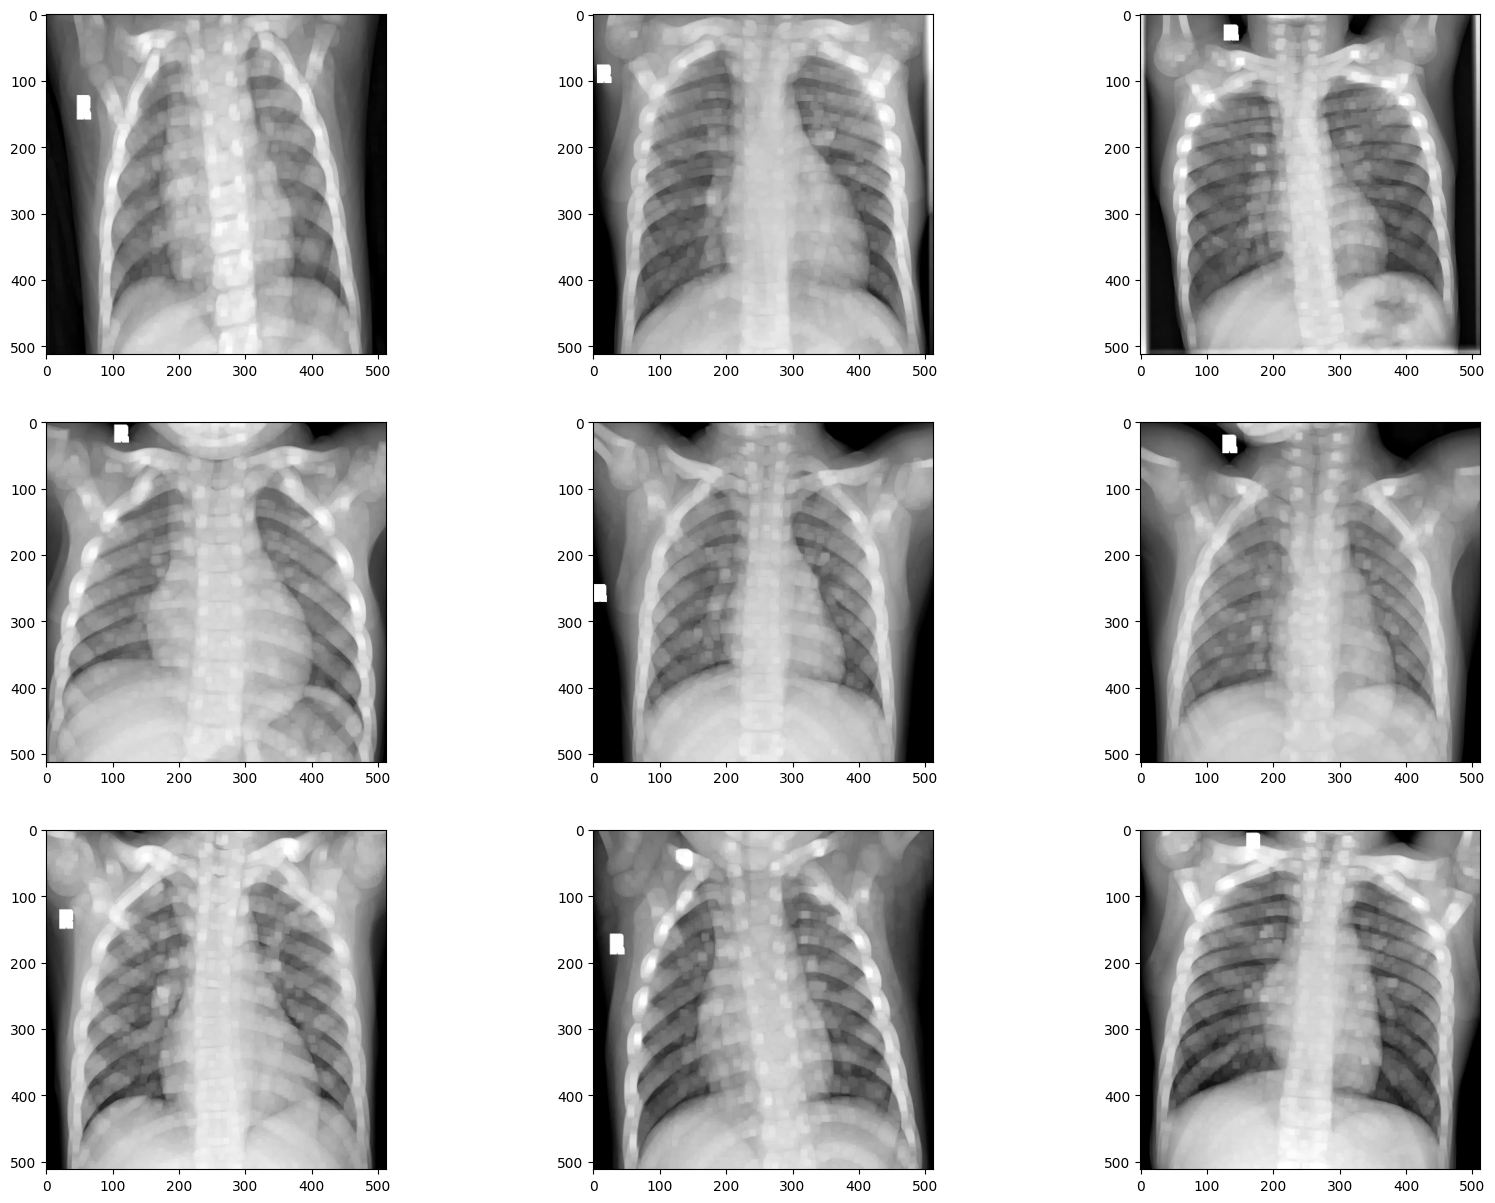

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

**Convert the images to greyscale and then apply Gaussian blur to them**

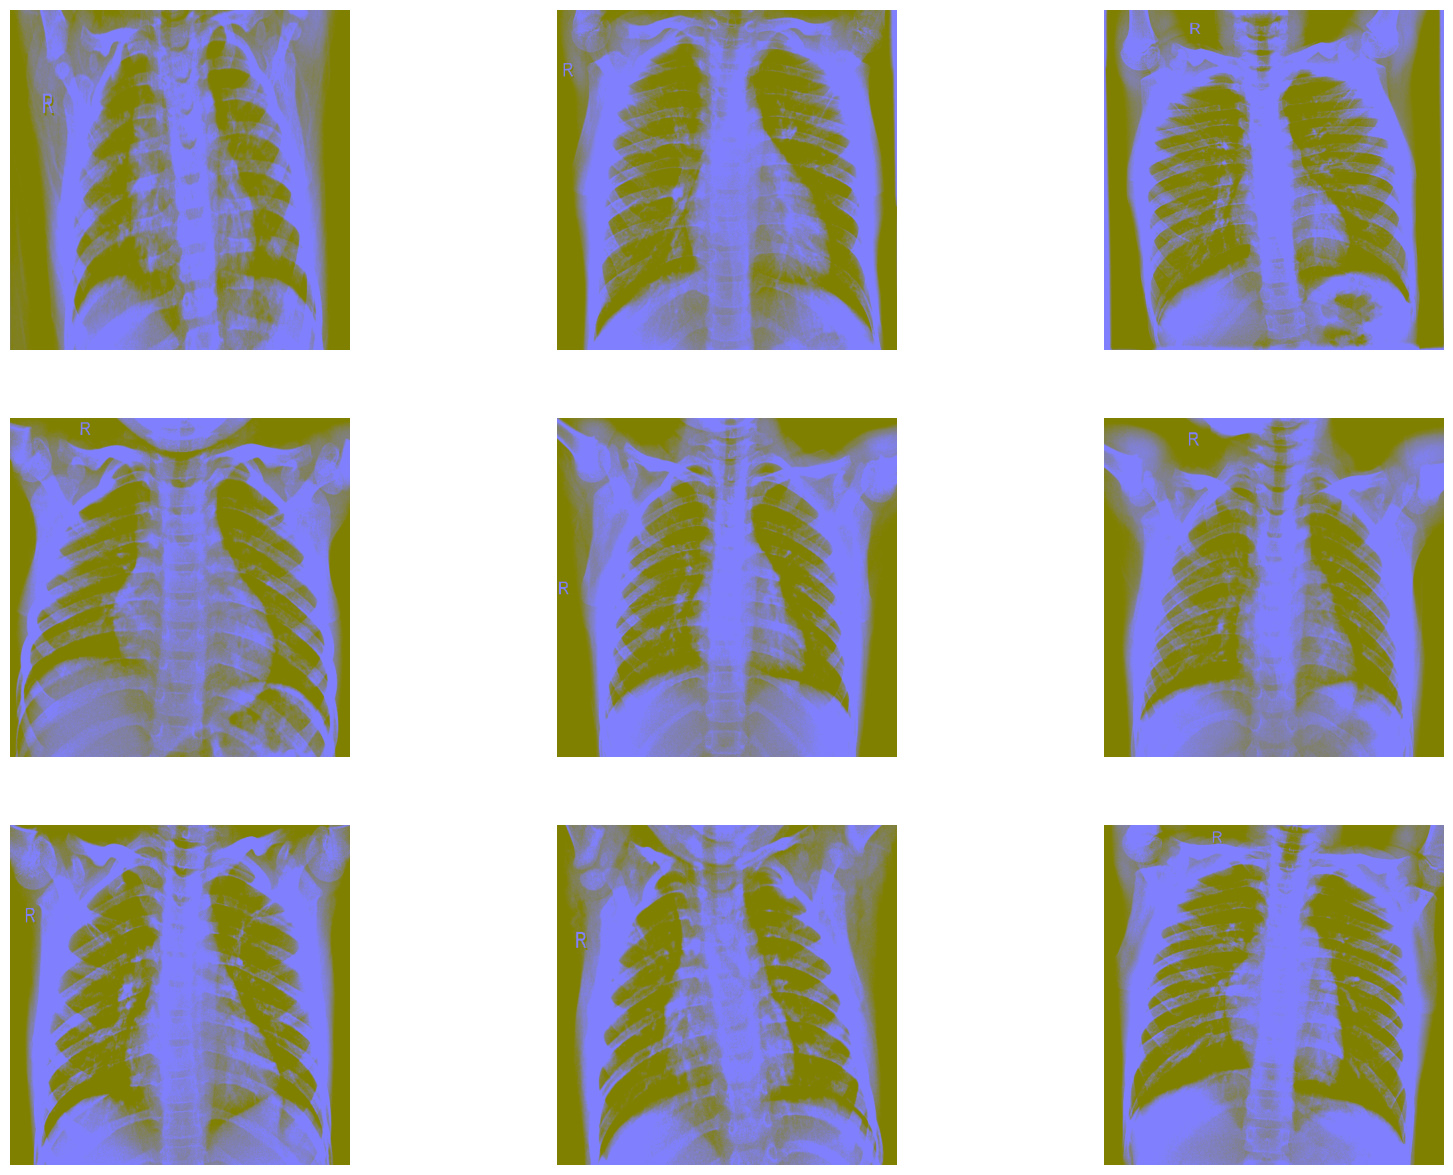

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

**Canny edge detection:
Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. It has been widely applied in various computer vision systems**

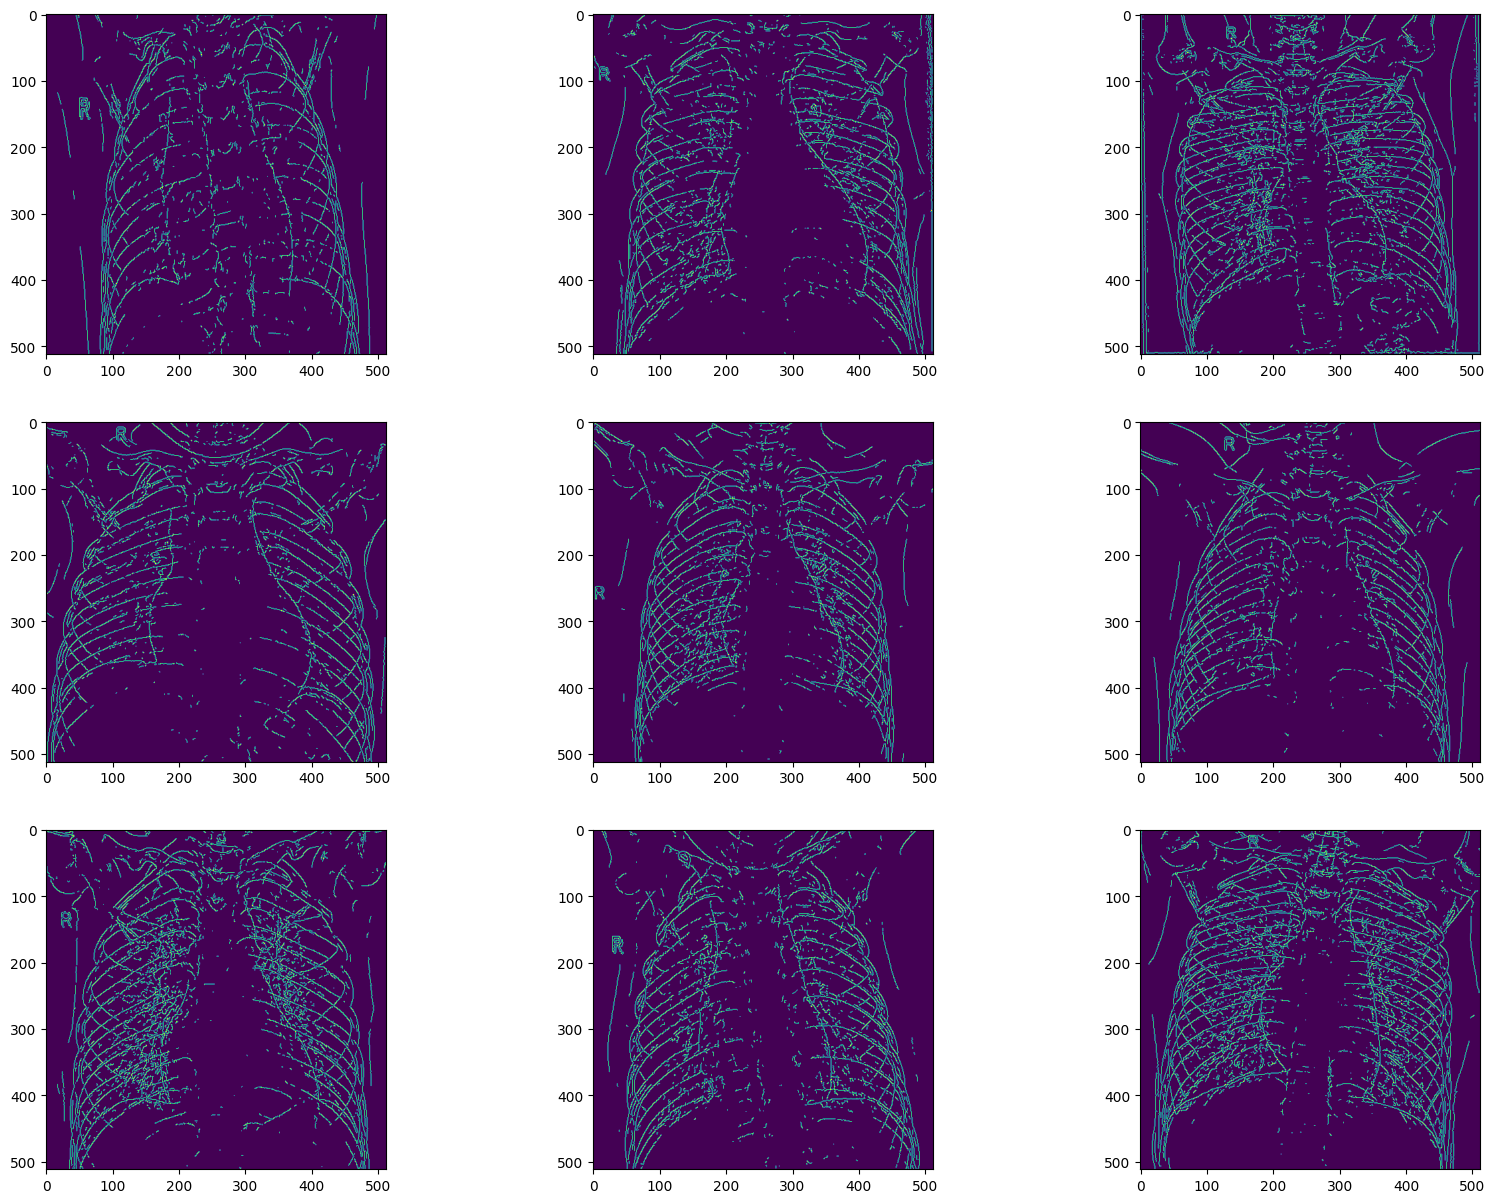

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

In [ ]:
train_dir = "/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/train"
test_dir = "/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test"
validation_dir = "/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/val"

In [ ]:
train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Cache and prefetch data ¶
If we use flow_from_directory along with ImageDataGenerator() to set up the dataset, it will not be compatible with tensorflow.data.AUTOTUNE. Use tensorflow.keras.preprocessing.image_dataset_from_directory instead to load the dataset**

In [ ]:
'''
AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size = AUTOTUNE)
'''
pass

In [ ]:
model1 = Sequential()

#convolutional neural networks - CNNs
model1.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", input_shape = (224, 224, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())

#fully connected layer
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       7

In [ ]:
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

**Train model**

In [ ]:
early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

In [ ]:
history = model1.fit_generator(train_set, epochs = 20,
                              validation_data = validation_set,
                              steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 394s 4s/step - loss: 0.5663 - accuracy: 0.7400 - val_loss: 0.9269 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 329s 3s/step - loss: 0.4383 - accuracy: 0.7931 - val_loss: 0.4430 - val_accuracy: 0.8125
Epoch 3/20
100/100 [==============================] - 318s 3s/step - loss: 0.3890 - accuracy: 0.8156 - val_loss: 0.8689 - val_accuracy: 0.6875
Epoch 4/20
100/100 [==============================] - 325s 3s/step - loss: 0.3694 - accuracy: 0.8275 - val_loss: 1.4987 - val_accuracy: 0.6250
Epoch 5/20
100/100 [==============================] - 320s 3s/step - loss: 0.3466 - accuracy: 0.8444 - val_loss: 0.6223 - val_accuracy: 0.6875
Epoch 6/20
100/100 [==============================] - 322s 3s/step - loss: 0.3404 - accuracy: 0.8450 - val_loss: 1.1637 - val_accuracy: 0.6250
Epoch 7/20
100/100 [==============================] - 304s 3s/step - loss: 0.3496 - accuracy: 0.8438 - val_loss: 1.0204 - val_accuracy: 0.5625

In [ ]:
model1.input, model1.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'conv2d_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>)

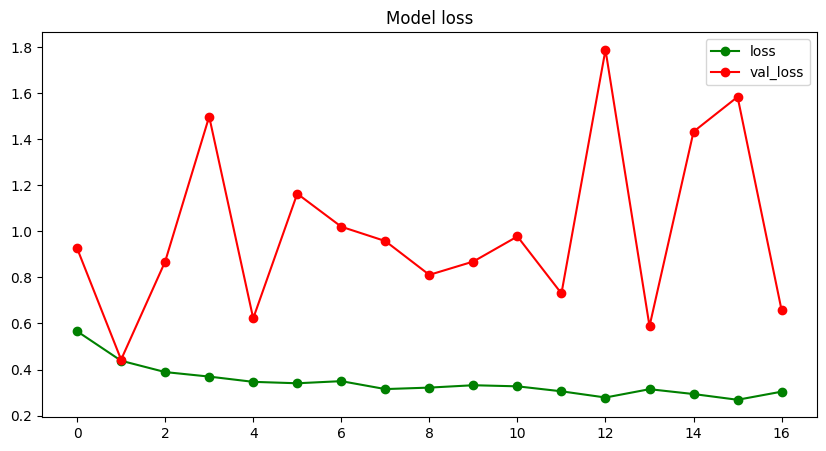

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

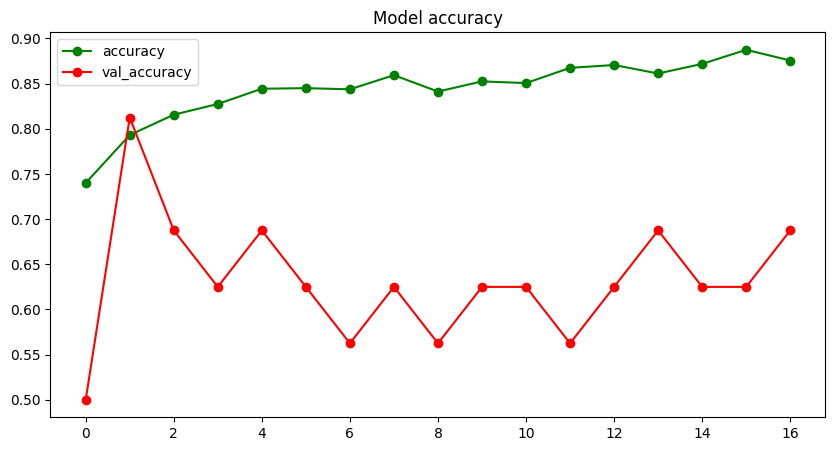

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

**Evaluate model 1 on test**

In [ ]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model1.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

39/50 [======================>.......] - ETA: 45s - loss: 0.5598 - accuracy: 0.6971

50/50 [==============================] - 159s 3s/step - loss: 0.5598 - accuracy: 0.6971
The testing accuracy is:  69.71153616905212 %
The testing loss is:  55.97625970840454 %


**Transfer larning
VGG16**

In [ ]:
base_model1 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max",
                    classes = 2)

#base_model1.load_weights("../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")
base_model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:

history = model2.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 50,callbacks = [early_stopping_callbacks])

Epoch 1/20
50/50 [==============================] - 488s 10s/step - loss: 0.5281 - accuracy: 0.7362 - val_loss: 0.6043 - val_accuracy: 0.6250
Epoch 2/20
50/50 [==============================] - 481s 10s/step - loss: 0.3371 - accuracy: 0.8313 - val_loss: 0.4719 - val_accuracy: 0.7500
Epoch 3/20
50/50 [==============================] - 477s 9s/step - loss: 0.3436 - accuracy: 0.8375 - val_loss: 0.4127 - val_accuracy: 0.7500
Epoch 4/20
50/50 [==============================] - 481s 10s/step - loss: 0.3370 - accuracy: 0.8400 - val_loss: 0.6810 - val_accuracy: 0.6875
Epoch 5/20
50/50 [==============================] - 481s 10s/step - loss: 0.2887 - accuracy: 0.8813 - val_loss: 0.4209 - val_accuracy: 0.7500
Epoch 6/20
50/50 [==============================] - 483s 10s/step - loss: 0.2864 - accuracy: 0.8662 - val_loss: 1.0858 - val_accuracy: 0.6875
Epoch 7/20
50/50 [==============================] - 489s 10s/step - loss: 0.2633 - accuracy: 0.8900 - val_loss: 0.9737 - val_accuracy: 0.6875
Epoch 8

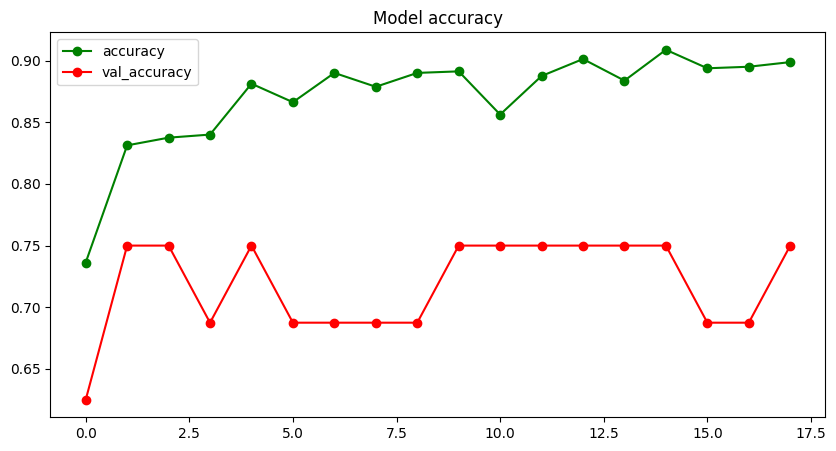

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

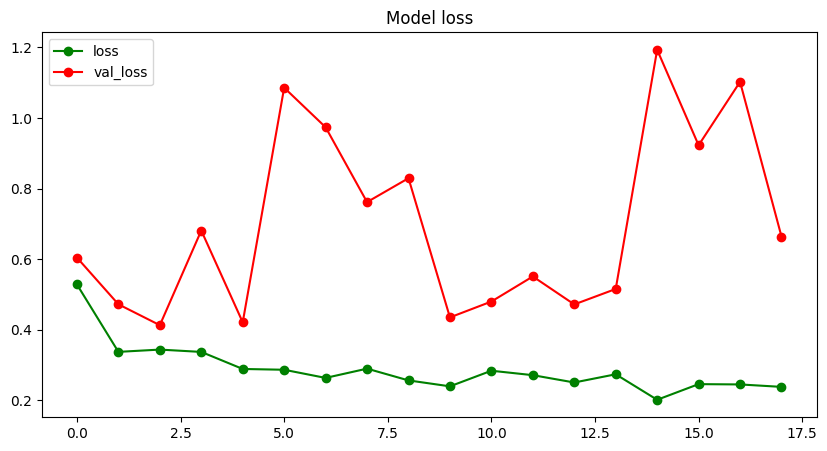

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [ ]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model2.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

39/50 [======================>.......] - ETA: 1:39 - loss: 0.4537 - accuracy: 0.7821

50/50 [==============================] - 355s 7s/step - loss: 0.4537 - accuracy: 0.7821
The testing accuracy is:  78.20512652397156 %
The testing loss is:  45.37057280540466 %


**ResNet50**

In [ ]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False

base_model2.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

In [ ]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model3.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 50,callbacks = [early_stopping_callbacks])

Epoch 1/20
50/50 [==============================] - 153s 3s/step - loss: 0.5806 - accuracy: 0.7912 - val_loss: 0.3958 - val_accuracy: 0.8750
Epoch 2/20
50/50 [==============================] - 137s 3s/step - loss: 0.4053 - accuracy: 0.8200 - val_loss: 0.3999 - val_accuracy: 0.8125
Epoch 3/20
50/50 [==============================] - 139s 3s/step - loss: 0.2102 - accuracy: 0.9038 - val_loss: 0.4051 - val_accuracy: 0.8125
Epoch 4/20
50/50 [==============================] - 136s 3s/step - loss: 0.2704 - accuracy: 0.8975 - val_loss: 0.4063 - val_accuracy: 0.8750
Epoch 5/20
50/50 [==============================] - 135s 3s/step - loss: 0.1967 - accuracy: 0.9325 - val_loss: 0.4293 - val_accuracy: 0.8125
Epoch 6/20
50/50 [==============================] - 147s 3s/step - loss: 0.3262 - accuracy: 0.8737 - val_loss: 0.6459 - val_accuracy: 0.7500
Epoch 7/20
50/50 [==============================] - 138s 3s/step - loss: 0.2383 - accuracy: 0.8913 - val_loss: 0.4205 - val_accuracy: 0.8750
Epoch 8/20
50

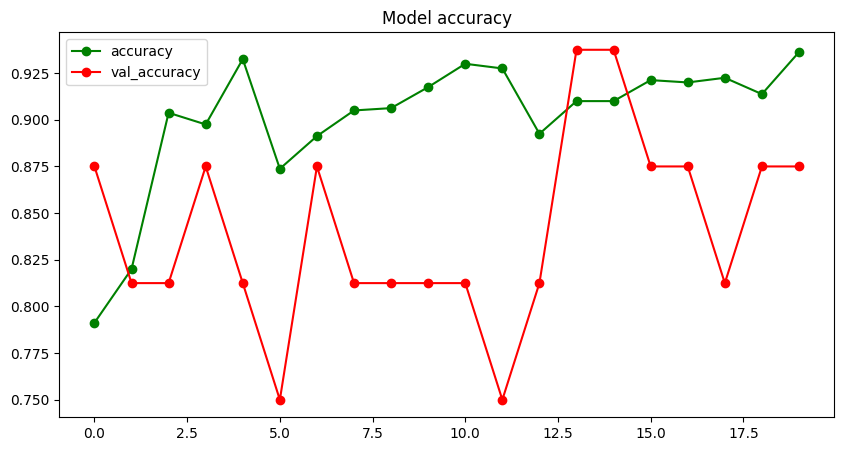

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

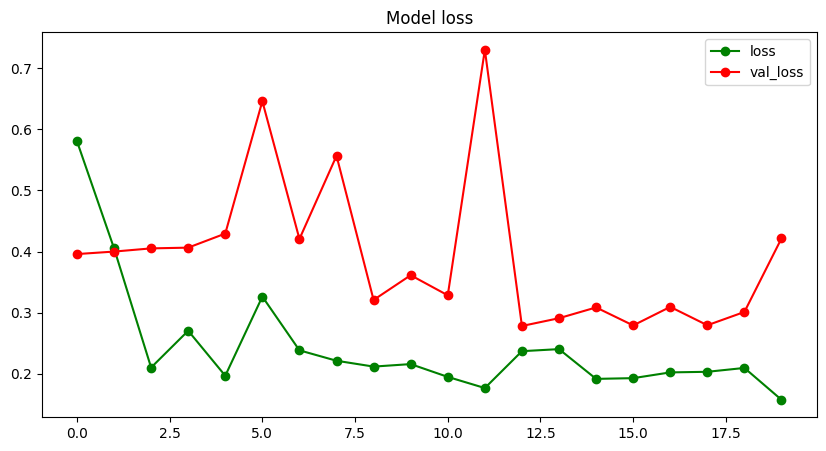

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [ ]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

39/50 [======================>.......] - ETA: 27s - loss: 0.3395 - accuracy: 0.8702

50/50 [==============================] - 97s 2s/step - loss: 0.3395 - accuracy: 0.8702
The testing accuracy is:  87.0192289352417 %
The testing loss is:  33.94809663295746 %


**Prediction of new image**

In [ ]:
new_image_path = "/content/IM-0029-0001.jpeg"
test_image = image.load_img(new_image_path, target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
#test_image = np.reshape(test_image, (1, 224, 224, 3))
test_image = test_image / 255

#___________________________________________________________________

result = model3.predict(test_image)
train_set.class_indices
if result[0][0] == 0:
    prediction = "N O R M A L"
else:
    prediction = "P N E U M O N I A"

print(prediction)

1/1 [==============================] - 2s 2s/step
P N E U M O N I A


**Save model to disk**

In [ ]:
model3.save("my_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

Model3 was succesfully saved to disk...


In [ ]:
model_loaded = tensorflow.keras.models.load_model("/content/my_pneumonia_detection_model.h5")
model_loaded.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23,837,441
Trainable params: 272,641
Non

**Use loaded model to predict new image**

1/1 [==============================] - 2s 2s/step
This image is 74.168 percent N O R M A L


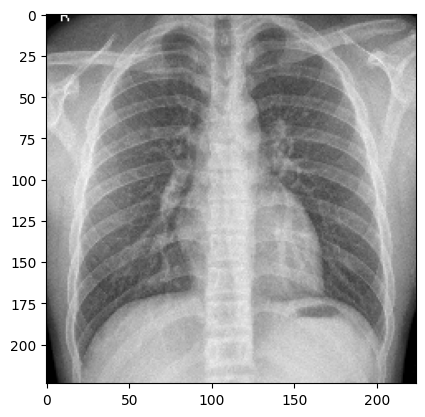

In [ ]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("/content/my_pneumonia_detection_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))


# call and use the function
image_prediction("/content/IM-0029-0001.jpeg")

**Get test data and test labels**

In [ ]:
test_dir = "/content/drive/MyDrive/Pneumonia_prediction/dataset_pneumonia/chest_xray/test"
test_data, test_labels = [], []

In [ ]:
for i in ["/NORMAL/", "/PNEUMONIA/"]:
    for image in (os.listdir(test_dir + i)):
        image = plt.imread(test_dir + i + image)
        image = cv2.resize(image, (224, 224))
        image = np.dstack([image, image, image])
        image = image.astype("float32") / 255
        if i == "/NORMAL/":
            label = 0
        elif i == "/PNEUMONIA/":
            label = 1
        test_data.append(image)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

_______C o n f u s i o n   m a t r i x_______

20/20 [==============================] - 100s 5s/step


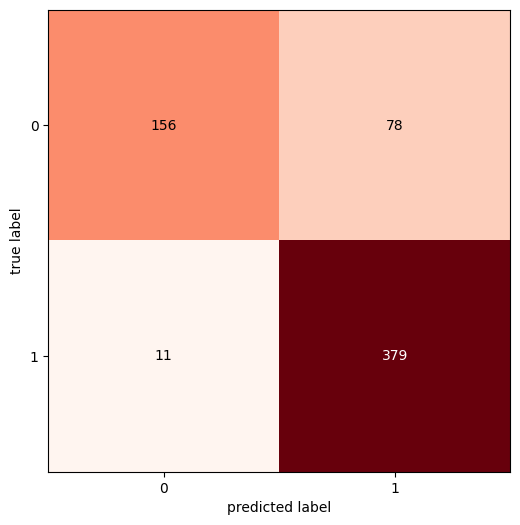

In [ ]:
print("_______C o n f u s i o n   m a t r i x_______\n")

predictions = model_loaded.predict(test_data)
conf_m = confusion_matrix(test_labels, np.round(predictions))
acc = accuracy_score(test_labels, np.round(predictions)) * 100
tn, fp, fn, tp = conf_m.ravel()

fig, ax = plot_confusion_matrix(conf_mat = conf_m, figsize = (6, 6), cmap = matplotlib.pyplot.cm.Reds)
plt.show()

In [ ]:

precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print("Accuracy: {}%".format(acc))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}".format(2 * precision * recall / (precision + recall)))

Accuracy: 85.73717948717949%
Precision: 82.93216630196937%
Recall: 97.17948717948718%
F1-score: 89.49232585596222


**Let's display correct and incorrect predicted classes**

In [ ]:
predictions = list()
preds = model_loaded.predict(test_data)
for i in preds:
    if i >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
predictions[:15]

20/20 [==============================] - 95s 5s/step


[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**np.nonzero() function is used to compute the indices of the elements that are non-zero.**

In [ ]:
correct_predictions = np.nonzero(predictions == test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

# let's look at indices of correct predictions
print("Indices of correct predictions:\n", correct_predictions[:15])

# let's look at indices of incorrect correct predictions
print("\nIndices of incorrect predictions:\n", incorrect_predictions[:15])

Indices of correct predictions:
 [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

Indices of incorrect predictions:
 [ 1 18 25 26 27 35 38 46 48 51 56 62 66 72 82]


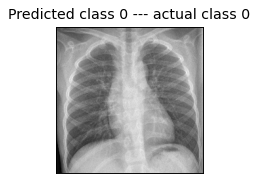

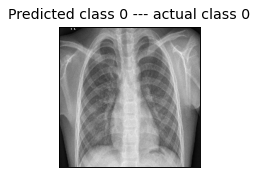

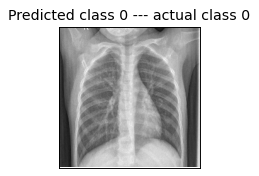

In [ ]:
# display correct predictions

i = 0
for a in correct_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([]), plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

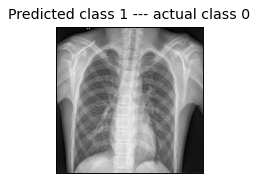

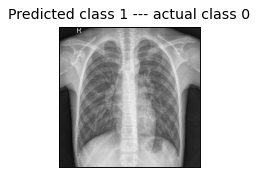

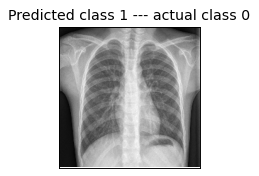

In [ ]:
# display incorrect predictions

i = 0
for a in incorrect_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1